In [19]:
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.basics import *
from torchvision.datasets import ImageFolder
import torchvision.models as models
np.random.seed(42)

import config
from data_utils import get_databunch

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# read imagenet data

In [2]:
args = config.read_config_from_file('default_config.yml')
args

{'data': '/home/pavel/data/ILSVRC/Data/CLS-LOC/',
 'checkpoints': '/media/pavel/storage/compression_checkpoints',
 'distributed': False,
 'workers': 4,
 'epochs': 90,
 'cycle_len': 1,
 'batch_size': 64,
 'val_batch_size': 200,
 'lr': 0.1,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'print_freq': 50,
 'resume': '',
 'pretrained': True,
 'fp16': True,
 'use_tta': True,
 'train_128': True,
 'image_size': 224,
 'loss_scale': 1.0,
 'prof': False,
 'world_size': 1,
 'rank': 0,
 'n_params': 26128614}

In [3]:
dataset = get_databunch(args['data'], 'labels_map.txt', args['image_size'], args['batch_size'], args['val_batch_size']) 
data = dataset.databunch(bs=args['batch_size'], val_bs=args['val_batch_size'])

In [4]:
data.show_batch(rows=3)

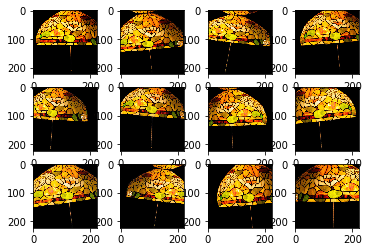

In [5]:
N, M = 3, 4
ind = np.random.randint(0, len(dataset.train))
_, axes = plt.subplots(N, M)
for i in range(N):
    for j in range(M):
        elem = dataset.train[ind][0]
        axes[i][j].imshow(elem.data.numpy().transpose((1, 2, 0)))

# reference model

In [4]:
model = models.resnet50().cuda()
# model.load_state_dict(torch.load('/home/pavel/skoltech/netcompression_v2/weights/ref_weigths.pkl'))

def dummy_model_constructor(*args, **hkwargs):
    return model

learner = cnn_learner(data, dummy_model_constructor, metrics=[accuracy, top_k_accuracy])

In [ ]:
learner.validate()

Exception ignored in: <function _releaseLock at 0x7f1bc98827b8>
Traceback (most recent call last):
  File "/home/pavel/miniconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


In [ ]:
learner.summary()

In [11]:
interp = learner.interpret()

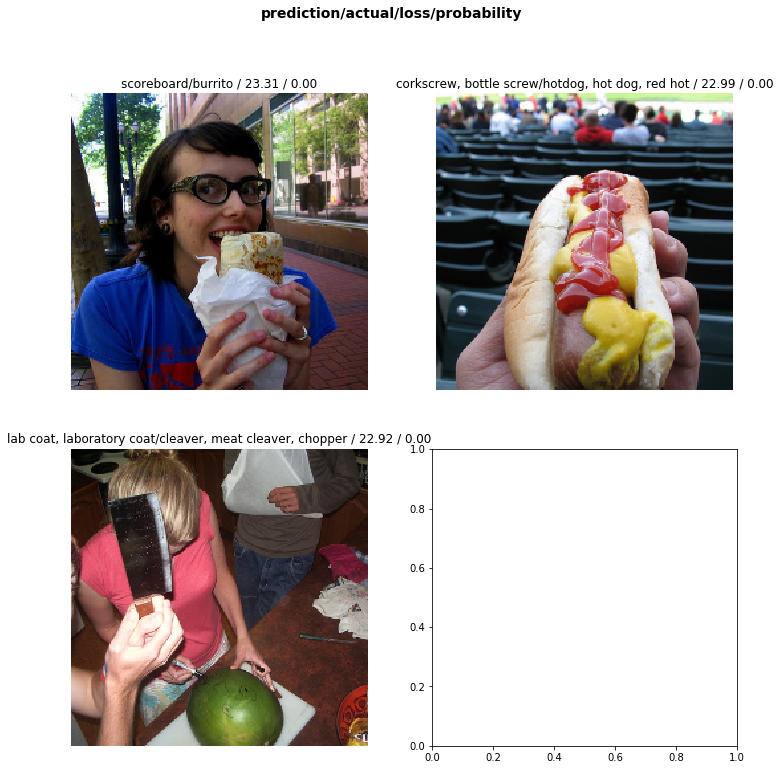

In [12]:
interp.plot_top_losses(3)

In [ ]:
learner.fit_one_cycle(1)

In [9]:
learner.validate()

[1.0727654, tensor(0.7470), tensor(0.9218)]

In [12]:
learner.save('/home/pavel/skoltech/netcompression_v2/weights/ref_learner.lrn')

Quality from torch docs: <br>
acc=74.15 <br>
top_5_akk=92.87 <br>

In [20]:
torch.save(model.state_dict(), 'weights/ref_weigths.pcl')

# let's decompose one layer and look at quality

In [4]:
model = models.resnet50().cuda()
# model.load_state_dict(torch.load('/home/pavel/skoltech/netcompression_v2/weights/ref_weigths.pkl'))

def dummy_model_constructor(*args, **hkwargs):
    return model

learner = cnn_learner(data, dummy_model_constructor, metrics=[accuracy, top_k_accuracy])

In [5]:
learner.load('/home/pavel/skoltech/netcompression_v2/weights/ref_learner.lrn')

Learner(data=ImageDataBunch;

Train: LabelList (1281167 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck
Path: /home/pavel/data/ILSVRC/Data/CLS-LOC;

Valid: LabelList (50000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck
Path: /home/pavel/data/ILSVRC/Data/CLS-LOC;

Test: LabelList (100000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/pavel/data/ILSVRC/Data/CLS-LOC, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 

In [6]:
learner.validate()

[1.0727655, tensor(0.7470), tensor(0.9218)]

In [6]:
from layer_decomposition import cp_decomposition_conv_layer
import model_utils as mu

Using numpy backend.


In [7]:
original_layer = learner.model[0][0]
decomposed_layer, rank, err, compression, n_params = cp_decomposition_conv_layer(original_layer, .4, sparse=True, sparsity_coeff=.01)
rank, err, compression, n_params

(16, 0.38705382, 5.326086956521739, 1766.4)

In [9]:
del original_layer
torch.cuda.empty_cache()

In [8]:
learner.model[0][0] = decomposed_layer.cuda()

In [9]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 224, 224]       48         True      
______________________________________________________________________
Conv2d               [16, 224, 224]       112        True      
______________________________________________________________________
Conv2d               [16, 112, 112]       112        True      
______________________________________________________________________
Conv2d               [64, 112, 112]       1,024      True      
______________________________________________________________________
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
___________________________________________________

In [10]:
_, acc, acc5 = learner.validate()
_, acc, acc5

(6.8851337, tensor(0.1585), tensor(0.3652))

In [11]:
learner.fit_one_cycle(1)

In [12]:
learner.fit_one_cycle(1)

In [13]:
_, acc, acc5 = learner.validate()
_, acc, acc5

(1.094464, tensor(0.7437), tensor(0.9192))

In [18]:
mu.checkpoint(0, learner, decomposed_layer, rank, err, compression,\
             mu.total_compression(args['n_params'], 1., int(n_params), compression), acc, acc5,\
             args['checkpoints'])

In [37]:
learner.unfreeze()

In [38]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [15, 224, 224]       45         True      
______________________________________________________________________
Conv2d               [15, 224, 224]       105        True      
______________________________________________________________________
Conv2d               [15, 112, 112]       105        True      
______________________________________________________________________
Conv2d               [64, 112, 112]       960        True      
______________________________________________________________________
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
___________________________________________________

In [41]:
learner.fit_one_cycle(1)

In [ ]:
learner.validate()

In [17]:
learner.save('/home/pavel/skoltech/netcompression_v2/weights/ind_0__sp__rank_16__acc_0.7424_acc5_0.9183')

In [17]:
learner.save('/home/pavel/skoltech/netcompression_v2/weights/ind_0__rank_18__acc_0.7424_acc5_0.9183')

# cuda memory clear

In [16]:
learner.purge()
gc.collect()
torch.cuda.empty_cache()

this Learner object self-destroyed - it still exists, but no longer usable


In [17]:
del model
torch.cuda.empty_cache()

# Loading custom ref model

In [1]:
from resnet50 import identity_resnet50
from model_utils import make_full_model

In [4]:
args = config.read_config_from_file('default_config.yml')
args

{'data': '/home/pavel/data/ILSVRC/Data/CLS-LOC/',
 'checkpoints': '/media/pavel/storage/compression_checkpoints',
 'distributed': False,
 'workers': 4,
 'epochs': 90,
 'cycle_len': 1,
 'batch_size': 64,
 'val_batch_size': 200,
 'lr': 0.1,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'print_freq': 50,
 'resume': '',
 'pretrained': True,
 'fp16': True,
 'use_tta': True,
 'train_128': True,
 'image_size': 224,
 'loss_scale': 1.0,
 'prof': False,
 'world_size': 1,
 'rank': 0,
 'n_params': 26128614}

In [5]:
dataset = get_databunch(args['data'], 'labels_map.txt', args['image_size'], args['batch_size'], args['val_batch_size']) 
data = dataset.databunch(bs=args['batch_size'], val_bs=args['val_batch_size'])

In [5]:
model = models.resnet50()
# model.load_state_dict(torch.load('/home/pavel/skoltech/netcompression_v2/weights/ref_weigths.pkl'))

def dummy_model_constructor(*args, **hkwargs):
    return model

learner = cnn_learner(data, dummy_model_constructor, metrics=[accuracy, top_k_accuracy])
learner.load('/home/pavel/skoltech/netcompression_v2/weights/ref_learner.lrn')

Learner(data=ImageDataBunch;

Train: LabelList (1281167 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck
Path: /home/pavel/data/ILSVRC/Data/CLS-LOC;

Valid: LabelList (50000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck
Path: /home/pavel/data/ILSVRC/Data/CLS-LOC;

Test: LabelList (100000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/pavel/data/ILSVRC/Data/CLS-LOC, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 

In [6]:
ref_model = learner.model.cpu()
ref_modules = []
for elem in ref_model.modules():
    if isinstance(elem, nn.Conv2d) or isinstance(elem, nn.Linear) or isinstance(elem, nn.BatchNorm2d):
        ref_modules.append(elem)

del model 
learner.destroy()
gc.collect()
torch.cuda.empty_cache()

len(ref_modules)

NameError: name 'learner' is not defined

In [7]:
ref_modules[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [16]:
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size(), obj.device, type(obj.device))
    except:
        pass

/home/pavel/miniconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:100: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


this object has been destroyed
this object has been destroyed
<class 'torch.nn.parameter.Parameter'> torch.Size([999, 512]) cpu <class 'torch.device'>
<class 'torch.nn.parameter.Parameter'> torch.Size([999]) cpu <class 'torch.device'>
<class 'torch.Tensor'> torch.Size([4]) cpu <class 'torch.device'>
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7]) cpu <class 'torch.device'>
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cpu <class 'torch.device'>
<class 'torch.nn.parameter.Parameter'> torch.Size([64]) cpu <class 'torch.device'>
<class 'torch.Tensor'> torch.Size([64]) cpu <class 'torch.device'>
<class 'torch.Tensor'> torch.Size([64]) cpu <class 'torch.device'>
<class 'torch.Tensor'> torch.Size([]) cpu <class 'torch.device'>
<class 'torch.nn.parameter.Parameter'> torch.Size([4096]) cpu <class 'torch.device'>
<class 'torch.nn.parameter.Parameter'> torch.Size([4096]) cpu <class 'torch.device'>
<class 'torch.Tensor'> torch.Size([4096]) cpu <class 'torch.device'>
<cl

In [8]:
import pickle

In [23]:
with open('1.pkl', 'wb') as f:
    pickle.dump(ref_modules[0], f)

In [25]:
with open('1.pkl', 'rb') as f:
    new_layer = pickle.load(f)

In [29]:
reconstructed_model = make_full_model([new_layer], ref_modules)

In [30]:
reconstructed_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
model = reconstructed_model 
# model.load_state_dict(torch.load('/home/pavel/skoltech/netcompression_v2/weights/ref_weigths.pkl'))

def dummy_model_constructor(*args, **hkwargs):
    return model

learner = cnn_learner(data, dummy_model_constructor, metrics=[accuracy, top_k_accuracy])
learner.load('/home/pavel/skoltech/netcompression_v2/weights/ref_learner.lrn')

Learner(data=ImageDataBunch;

Train: LabelList (1281167 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck
Path: /home/pavel/data/ILSVRC/Data/CLS-LOC;

Valid: LabelList (50000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck,fire engine, fire truck
Path: /home/pavel/data/ILSVRC/Data/CLS-LOC;

Test: LabelList (100000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/pavel/data/ILSVRC/Data/CLS-LOC, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 

In [32]:
learner.validate()

[1.0727655, tensor(0.7470), tensor(0.9218)]

In [9]:
from sparse_parafac import sparse_parafac

Using numpy backend.


In [11]:
(last, first, vertical, horizontal), S, errs = sparse_parafac(ref_modules[0].weight.data.cpu().numpy(), rank=16,
                                                                          init='random',
                                                                 return_errors=True, card=.01)
errs

[0.6327891,
 0.5254555,
 0.49644473,
 0.48077378,
 0.47243077,
 0.46601048,
 0.46136725,
 0.45702857,
 0.45442492,
 0.45233926,
 0.45021135,
 0.4477002,
 0.4461093,
 0.44433632,
 0.4429793,
 0.44132504,
 0.44007537,
 0.4387409,
 0.43756282,
 0.436126,
 0.43494517,
 0.43293986,
 0.43137503,
 0.43008327,
 0.42905438,
 0.42785057,
 0.42621276,
 0.42418993,
 0.4229095,
 0.42079318,
 0.41939515,
 0.41844434,
 0.41701782,
 0.41551226,
 0.41445124,
 0.4137915,
 0.4132254,
 0.41272196,
 0.412267,
 0.41185248,
 0.41147253,
 0.41111615,
 0.4104994,
 0.4098762,
 0.4094818,
 0.4091601,
 0.4088613,
 0.40819383,
 0.40771136,
 0.4068135,
 0.4062734,
 0.40579325,
 0.40534472,
 0.40491876,
 0.4045088,
 0.40396318,
 0.40338978,
 0.40275782,
 0.4023114,
 0.40190202,
 0.40151492,
 0.4011456,
 0.40079194,
 0.40045244,
 0.40012655,
 0.39981353,
 0.39951304,
 0.39922494,
 0.3989484,
 0.39868307,
 0.39842865,
 0.39818457,
 0.3979428,
 0.3974997,
 0.3972227,
 0.39697853,
 0.3967503,
 0.39653474,
 0.39632964,
 

In [12]:
def sparsity(A):
    m = 1
    for elem in A.shape:
        m *= elem
    return len(A.nonzero()[0])/m

In [13]:
sparsity(S)

0.009991496598639456

In [14]:
sparse_layer = deepcopy(ref_modules[0])
sparse_layer.weight = nn.Parameter(torch.tensor(S))

In [15]:
sparse_layer.weight

Parameter containing:
tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        

In [33]:
f'{15:03}'

'015'

# load from checkpoint

In [5]:
from resnet50 import identity_resnet50
from layer_decomposition import cp_decomposition_conv_layer
import model_utils as mu

Using numpy backend.


In [6]:
ind, learner = mu.load_checkpoint(args['checkpoints'], data, ind=0)
ind

0

In [7]:
learner.validate()

[1.094464, tensor(0.7437), tensor(0.9192)]

In [8]:
ind += 1

TODO: дописать адресацию слоев

In [9]:
original_layer = learner.model[0][4][0].conv2
sparsity_coeff = 0.01
decomposed_layer, rank, err, compression, n_params = cp_decomposition_conv_layer(original_layer, .5, sparse=True, sparsity_coeff=sparsity_coeff)
rank, err, compression, n_params

(19, 0.4921873, 8.398797047297913, 36864)

In [10]:
learner.model[0][4][0].conv2 = decomposed_layer.cuda()

In [11]:
_, acc, acc5 = learner.validate()
_, acc, acc5

(1.222093, tensor(0.7187), tensor(0.9033))

In [12]:
learner.fit_one_cycle(1)

In [33]:
learner.fit_one_cycle(1)

In [34]:
_, acc, acc5 = learner.validate()
_, acc, acc5

(1.0995331, tensor(0.7433), tensor(0.9192))

In [13]:
mu.checkpoint(ind, learner, decomposed_layer, int(n_params), rank, sparsity_coeff, err, compression,\
             mu.total_compression(args['n_params'], 1., int(n_params), compression), acc, acc5,\
             args['checkpoints'])

In [36]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 224, 224]       48         False     
______________________________________________________________________
Conv2d               [16, 224, 224]       112        False     
______________________________________________________________________
Conv2d               [16, 112, 112]       112        False     
______________________________________________________________________
Conv2d               [64, 112, 112]       1,024      False     
______________________________________________________________________
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
___________________________________________________

In [38]:
learner.model[0][4][0].conv2.mask

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

    

In [14]:
learner.purge()

PicklingError: Can't pickle <class 'resnet50.Bottleneck'>: it's not the same object as resnet50.Bottleneck

In [18]:
learner.model

Sequential(
  (0): Sequential(
    (0): SparseConv2d(
      (low_rank): Sequential(
        (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(16, 16, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), groups=16, bias=False)
        (2): Conv2d(16, 16, kernel_size=(1, 7), stride=(2, 2), padding=(0, 3), groups=16, bias=False)
        (3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (sparse): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): SparseConv2d(
      

# Model construction debuging

In [16]:
from resnet50 import identity_resnet50
from layer_decomposition import cp_decomposition_conv_layer
import model_utils as mu

In [17]:
model = mu.make_original_model()

In [30]:
ind, learner = mu.load_checkpoint(args['checkpoints'], data, 666)

# Iterative training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.basics import *
from torchvision.datasets import ImageFolder
import torchvision.models as models
np.random.seed(42)

import config
from data_utils import get_databunch

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 9)

In [9]:
from resnet50 import identity_resnet50
from layer_decomposition import cp_decomposition_conv_layer
import layer_decomposition as ld
import model_utils as mu

In [3]:
args = config.read_config_from_file('default_config.yml')
args

{'data': '/home/pavel/data/ILSVRC/Data/CLS-LOC/',
 'checkpoints': '/media/pavel/storage/compression_checkpoints2',
 'distributed': False,
 'workers': 4,
 'epochs': 90,
 'cycle_len': 1,
 'batch_size': 64,
 'val_batch_size': 200,
 'lr': 0.1,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'print_freq': 50,
 'resume': '',
 'pretrained': True,
 'fp16': True,
 'use_tta': True,
 'train_128': True,
 'image_size': 224,
 'loss_scale': 1.0,
 'prof': False,
 'world_size': 1,
 'rank': 0,
 'n_params': 26128614}

In [4]:
dataset = get_databunch(args['data'], 'labels_map.txt', args['image_size'], args['batch_size'], args['val_batch_size']) 
data = dataset.databunch(bs=args['batch_size'], val_bs=args['val_batch_size'])

In [21]:
total_compression = 1.

In [6]:
ind, learner = mu.load_checkpoint(args['checkpoints'], data, 666)
print(ind)
learner.validate()

[1.2619519, tensor(0.7037), tensor(0.8974)]

In [7]:
ind += 1

In [8]:
original_layer = mu.get_layer_by_ind(learner, ind) 
sparsity_coeff = 0.01
decomposed_layer, rank, err, compression, n_params = cp_decomposition_conv_layer(original_layer, .4, sparse=True, sparsity_coeff=sparsity_coeff)
rank, err, compression, n_params

(68, 0.398072, 3.3649773623484736, 36864)

In [12]:
biba = ld.get_weights_from_decomposed_layer(decomposed_layer)
len(biba)

5

In [16]:
new_dlayer = ld.decomposition_from_weights_conv_layer(original_layer, *biba)
new_dlayer

SparseConv2d(
  (low_rank): Sequential(
    (0): Conv2d(64, 68, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(68, 68, kernel_size=(1, 1), stride=(1, 1), padding=(1, 0), groups=68, bias=False)
    (2): Conv2d(68, 68, kernel_size=(1, 1), stride=(1, 1), padding=(0, 1), groups=68, bias=False)
    (3): Conv2d(64, 68, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (sparse): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [15]:
_, acc, acc5 = learner.validate()
_, acc, acc5

(1.0727655, tensor(0.7470), tensor(0.9218))

In [26]:
torch.zeros(biba[0].shape).shape

torch.Size([64, 68, 1, 1])

In [16]:
learner.fit_one_cycle(1)

In [17]:
learner.fit_one_cycle(1)

In [18]:
_, acc, acc5 = learner.validate()
_, acc, acc5

(1.0714188, tensor(0.7508), tensor(0.9221))

In [22]:
total_compression = mu.total_compression(args['n_params'], total_compression, int(n_params), compression)
mu.checkpoint(ind, learner, int(n_params), tuple(original_layer.weight.shape), rank, \
              sparsity_coeff, err, compression,\
             total_compression, acc, acc5,\
             args['checkpoints'])

In [26]:
learner.purge()
learner.destroy()
gc.collect()
torch.cuda.empty_cache()

this object has been destroyed
this object has been destroyed


## main cycle

In [18]:
def printlog(ind, shape=None, rank=None, err=None, compression=None, n_params=None,
            prior_acc=None, prior_acc5=None,
            acc=None, acc5=None):
    print('\n')
    print(f'ind: {ind}')
    print(f'shape: {shape}')
    print(f'rank: {rank}, err: {err}, compression: {compression}, n_params: {n_params}')
    print(f'prior acc: {prior_acc}, top5: {prior_acc5}') 
    print(f'posterior acc: {acc}, top5: {acc5}') 

In [34]:
total_compression = 1 
ind = -1
while ind <= 52:
    ind, learner = mu.load_checkpoint(args['checkpoints'], data, 666)
#     print(f'ind loaded: {ind}')
    printlog(ind)
    ind += 1
    
    original_layer = mu.get_layer_by_ind(learner, ind) 
    shape = original_layer.weight.shape
    sparsity_coeff = 0.01
    decomposed_layer, rank, err, compression, n_params = cp_decomposition_conv_layer(original_layer, .8, sparse=True, sparsity_coeff=sparsity_coeff)
    rank, err, compression, n_params
    printlog(ind, shape, rank, err, compression, n_params)
#     print(f'rank: {rank}, err: {err}, compression: {compression}, n_params: {n_params}')
    
    for i in range(ind):
        layer = mu.get_layer_by_ind(learner, i)
        for p in layer.parameters():
            p.requires_grad = True
            
    mu.set_layer_by_ind(learner, decomposed_layer.cuda(), ind)
    
    _, p_acc, p_acc5 = learner.validate()
    print(learner.summary())
    printlog(ind, shape, rank, err, compression, n_params, p_acc, p_acc5)
#     print(f'prior acc: {p_acc}, top5: {p_acc5}') 
    learner.fit_one_cycle(2)
    _, acc, acc5 = learner.validate()
    printlog(ind, shape, rank, err, compression, n_params, p_acc, p_acc5, acc, acc5)
#     print(f'posterior acc: {acc}, top5: {acc5}') 
    
    total_compression = mu.total_compression(args['n_params'], total_compression, int(n_params), compression)
    mu.checkpoint(ind, learner, tuple(original_layer.weight.shape), int(n_params), rank, \
                  sparsity_coeff, err, compression,\
                 total_compression, acc, acc5,\
                 args['checkpoints'])
    
    learner.purge()
    learner.destroy()
    gc.collect()
    torch.cuda.empty_cache()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [2, 224, 224]        6          True      
______________________________________________________________________
Conv2d               [2, 224, 224]        14         True      
______________________________________________________________________
Conv2d               [2, 112, 112]        14         True      
______________________________________________________________________
Conv2d               [64, 112, 112]       128        True      
______________________________________________________________________
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
___________________________________________________

KeyboardInterrupt: 

In [33]:
for p in layer.parameters():
    print(p.shape)

torch.Size([2, 64, 1, 1])
torch.Size([2, 1, 1, 1])
torch.Size([2, 1, 1, 1])
torch.Size([64, 2, 1, 1])
torch.Size([64, 64, 1, 1])


In [ ]:
learner.

In [19]:
printlog(ind, shape, rank, err, compression, n_params)



ind: 0
shape: torch.Size([64, 3, 7, 7])
rank: 2, err: 0.7767553925514221, compression: 14.876660341555976, n_params: 9408
prior acc: None, top5: None
posterior acc: None, top5: None


In [13]:
decomposed_layer

SparseConv2d(
  (low_rank): Sequential(
    (0): Conv2d(3, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(2, 2, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), groups=2, bias=False)
    (2): Conv2d(2, 2, kernel_size=(1, 7), stride=(2, 2), padding=(0, 3), groups=2, bias=False)
    (3): Conv2d(2, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (sparse): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)

In [10]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [2, 224, 224]        6          True      
______________________________________________________________________
Conv2d               [2, 224, 224]        14         True      
______________________________________________________________________
Conv2d               [2, 112, 112]        14         True      
______________________________________________________________________
Conv2d               [64, 112, 112]       128        True      
______________________________________________________________________
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
___________________________________________________

In [43]:
learner.summary()

In [13]:
cur_layer = mu.get_layer_by_ind(learner, 42)

In [19]:
cur_layer.low_rank[0].weight.requires_grad

False

In [20]:
learner.validate()

[1.1274041, tensor(0.7365), tensor(0.9146)]

In [27]:
W = cur_layer.sparse.weight.cpu().detach().numpy()

In [32]:
cur_layer = cur_layer.train()

In [33]:
cur_layer.low_rank[0].weight.requires_grad

False

In [41]:
cur_layer.low_rank[0].weight.requires_grad

True

In [42]:
for i, p in enumerate(cur_layer.cuda().parameters()):
     p.requires_grad = True

# Look at error

In [7]:
filename = '/media/pavel/storage/compression_checkpoints_pardus/log.txt'
acc = []
acc5 = []
with open(filename, 'r') as f:
    for line in f:
        line = line.strip('\n\t')
        val = line.split('=')[-1]
        if line.startswith('accuracy'):
            acc.append(float(val))
        elif line.startswith('top5_acc'):
            acc5.append(float(val))
len(acc), len(acc5)

(53, 53)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

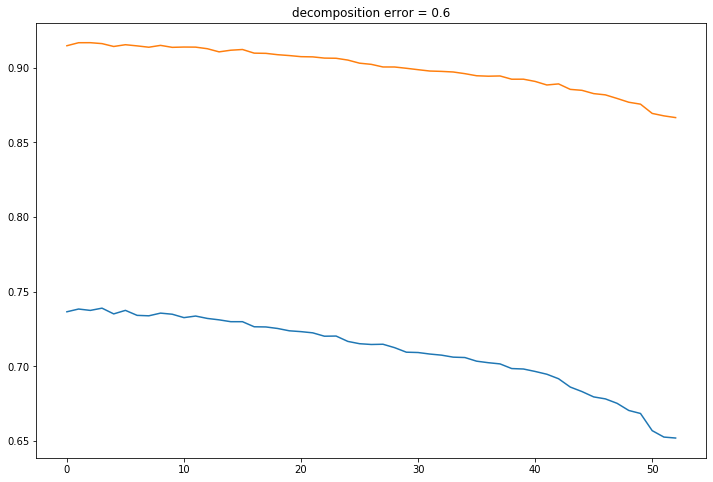

In [12]:
plt.title('decomposition error = 0.6')
plt.plot(acc, label='acc')
plt.plot(acc5, label='acc5')

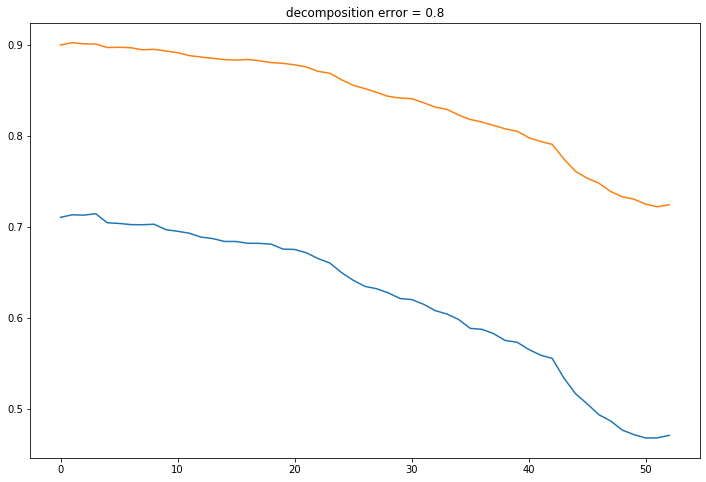

In [13]:
filename = '/media/pavel/storage/compression_checkpoints2/log.txt'
acc = []
acc5 = []
with open(filename, 'r') as f:
    for line in f:
        line = line.strip('\n\t')
        val = line.split('=')[-1]
        if line.startswith('accuracy'):
            acc.append(float(val))
        elif line.startswith('top5_acc'):
            acc5.append(float(val))
            
plt.title('decomposition error = 0.8')
plt.plot(acc, label='acc')
plt.plot(acc5, label='acc5')

# measure iference lower bound

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.basics import *
from torchvision.datasets import ImageFolder
import torchvision.models as models
np.random.seed(42)
from resnet50 import identity_resnet50
from layer_decomposition import cp_decomposition_conv_layer, SparseConv2d
import model_utils as mu

import config
from data_utils import get_databunch

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 9)

Using numpy backend.


In [2]:
args = config.read_config_from_file('default_config.yml')
args

{'data': '/home/pavel/data/ILSVRC/Data/CLS-LOC',
 'checkpoints': '/media/pavel/storage/compression_checkpoints_warden',
 'image_size': 224,
 'sparse': True,
 'sparsity_coeff': 0.01,
 'epochs': 90,
 'decomposition_error': 0.5,
 'batch_size': 64,
 'val_batch_size': 300,
 'n_params': 26128614}

In [3]:
X = torch.tensor(np.random.rand(64, 3, args['image_size'], args['image_size']).astype(np.float32), device='cuda')

## original model

In [4]:
model = models.resnet50().eval().cuda()

In [5]:
%%time
N = 1000
for _ in range(N):
    model(X)

CPU times: user 44.7 s, sys: 26 s, total: 1min 10s
Wall time: 1min 10s


## decomposed model

In [4]:
dataset = get_databunch(args['data'], 'labels_map.txt', args['image_size'], args['batch_size'], args['val_batch_size']) 
data = dataset.databunch(bs=args['batch_size'], val_bs=args['val_batch_size'])

In [5]:
ind, learner = mu.load_checkpoint(args['checkpoints'], data, ind=52)
ind

52

In [7]:
%%time
N = 100
for _ in range(N):
    learner.model(X)

CPU times: user 8.45 s, sys: 4.6 s, total: 13 s
Wall time: 13.9 s


In [6]:
learner.model

Sequential(
  (0): Sequential(
    (0): SparseConv2d(
      (low_rank): Sequential(
        (0): Conv2d(3, 11, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(11, 11, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), groups=11, bias=False)
        (2): Conv2d(11, 11, kernel_size=(1, 7), stride=(2, 2), padding=(0, 3), groups=11, bias=False)
        (3): Conv2d(11, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (sparse): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): SparseConv2d(
          (low_rank): Sequential(
            (0): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), gro

## LR only

In [7]:
for ind in range(52):
    layer = mu.get_layer_by_ind(learner, ind)
    layer = layer.low_rank
    if layer[1].kernel_size == (1, 1) and layer[1].stride == (1, 1) and layer[2].kernel_size == (1, 1) and layer[2].stride == (1, 1):
        layer[0].weight = nn.Parameter(layer[0].weight*layer[1].weight*layer[2].weight)
        layer = nn.Sequential(layer[0], layer[3])
    mu.set_layer_by_ind(learner, layer, ind)
learner.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 11, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(11, 11, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), groups=11, bias=False)
      (2): Conv2d(11, 11, kernel_size=(1, 7), stride=(2, 2), padding=(0, 3), groups=11, bias=False)
      (3): Conv2d(11, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Sequential(
          (0): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Sequential(
          (0): Conv2d(64, 20, kernel_

In [9]:
%%time
with torch.no_grad():
    N = 100
    for _ in range(N):
        learner.model(X)

CPU times: user 4.07 s, sys: 2.15 s, total: 6.22 s
Wall time: 6.22 s


In [10]:
6.23/6.78

0.9188790560471977

In [6]:
%%time
N = 100
for _ in range(N):
    model(X)

CPU times: user 4.39 s, sys: 2.4 s, total: 6.79 s
Wall time: 6.79 s


In [20]:
for module in learner.model.modules():
    print(type(module))

<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>
<class 'layer_decomposition.SparseConv2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'resnet50.Bottleneck'>
<class 'layer_decomposition.SparseConv2d'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'layer_decomposition.SparseConv2d'>
<class 'torch.nn.modules.

## Same for cpu only

In [3]:
X = torch.tensor(np.random.rand(64, 3, args['image_size'], args['image_size']).astype(np.float32))

In [24]:
model = models.resnet50().eval()

In [25]:
sum(p.numel() for p in model.parameters())

25557032

In [7]:
%%time
N = 10
for _ in range(N):
    model(X)

CPU times: user 2min 15s, sys: 13.2 s, total: 2min 29s
Wall time: 22.8 s


In [26]:
model(X).shape

torch.Size([64, 1000])

In [17]:
dataset = get_databunch(args['data'], 'labels_map.txt', args['image_size'], args['batch_size'], args['val_batch_size']) 
data = dataset.databunch(bs=args['batch_size'], val_bs=args['val_batch_size'])
ind, learner = mu.load_checkpoint(args['checkpoints'], data, ind=52)
model = learner.model.cpu()
ind

52

In [18]:
%%time
N = 10
for _ in range(N):
    model(X)

CPU times: user 4min 21s, sys: 50.4 s, total: 5min 12s
Wall time: 43.9 s


In [19]:
for ind in range(52):
    layer = mu.get_layer_by_ind(learner, ind)
    layer = layer.low_rank
    if layer[1].kernel_size == (1, 1) and layer[1].stride == (1, 1) and layer[2].kernel_size == (1, 1) and layer[2].stride == (1, 1):
        layer[0].weight = nn.Parameter(layer[0].weight*layer[1].weight*layer[2].weight)
        layer = nn.Sequential(layer[0], layer[3])
    mu.set_layer_by_ind(learner, layer, ind)
model = learner.model.cpu()

In [21]:
%%time
N = 10
for _ in range(N):
    model(X)

CPU times: user 2min 23s, sys: 20 s, total: 2min 42s
Wall time: 25.3 s


In [23]:
sum(p.numel() for p in model.parameters())

10819522